In [1]:
# Start client parallel processing

from dask.distributed import Client

client = Client(n_workers=12)
client

Client Scheduler: tcp://127.0.0.1:54715 Dashboard: http://127.0.0.1:40485/status,Cluster Workers: 12 Cores: 24 Memory: 33.55 GB


### Load data

In [3]:
import sys
import os
import numpy as np
import xarray as xr

sys.path.append('../b_Temporal_Stack')
import xr_eotemp

vars_location = os.environ['WIN_SVR_DATA']+'Saldana2/vars/'
int_location = os.environ['WIN_SVR_DATA']+'Saldana2/features/'

int_series = xr.open_mfdataset([int_location+x for x in os.listdir(int_location)],chunks={'y':100,'x':100,'time':22})

optical_ts = xr.open_mfdataset(list(map(lambda x: vars_location+x, ['landsat.nc','sentinel.nc'])),
                             chunks={'y':100,'x':100,'time':23})

### Display map to select area of interest

In [5]:
import pyproj
import IPython.display

from shapely import geometry
from ipyleaflet import Map
from ipyleaflet import DrawControl
from ipyleaflet.leaflet import TileLayer

In [11]:
%matplotlib inline

sat_url = "https://api.mapbox.com/styles/v1/asalazar/cjjjz8n1w56hx2snp8675oedp/tiles/256/{z}/{x}/{y}?access_token=pk.eyJ1IjoiYXNhbGF6YXIiLCJhIjoiY2pqano3YngxMGNoMDNycXF2dDhqOTRkYiJ9.MecIVccMuRf5zhm4rk7qHA"

m = Map(center=(4.6767, -71.2653), zoom=5)
dc = DrawControl()
st = TileLayer(opacity=1.0, url=sat_url, zoom=0, max_zoom=25, attribution='<a href=’https://mapbox.com’>Mapbox</a>')

m.add_layer(st)
m.add_control(dc)
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

- Retrieve area of interest from last drawn polygon in Map 

POLYGON ((501836.3643584131 431122.291358672, 501972.2520004144 431100.9608348549, 502196.1761029362 431150.706660394, 502284.3195147479 431380.1798318248, 501783.9548346003 431571.8369685897, 501736.3296055955 431481.9709571093, 501745.8781276896 431432.2302977055, 501836.3643584131 431122.291358672))


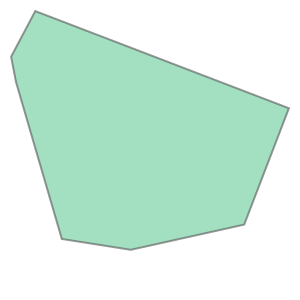

In [12]:
# Projection of the map
wgs84 = pyproj.Proj(init='epsg:4326')
# Projection of the dataset
wgs84_18N = pyproj.Proj(init='epsg:32618')
# Get and reproject geom coordinates
coords = [pyproj.transform(wgs84,wgs84_18N,x,y) for (x,y) in dc.last_draw['geometry']['coordinates'][0]]
# Make shapely polygon
polygon = geometry.polygon.Polygon(coords)
# Display polygon
print(polygon.wkt)
IPython.display.display(polygon)

- Verfiy that the polygon is correctly geo-referenced in the dataset by visualization of real color RGB bands 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


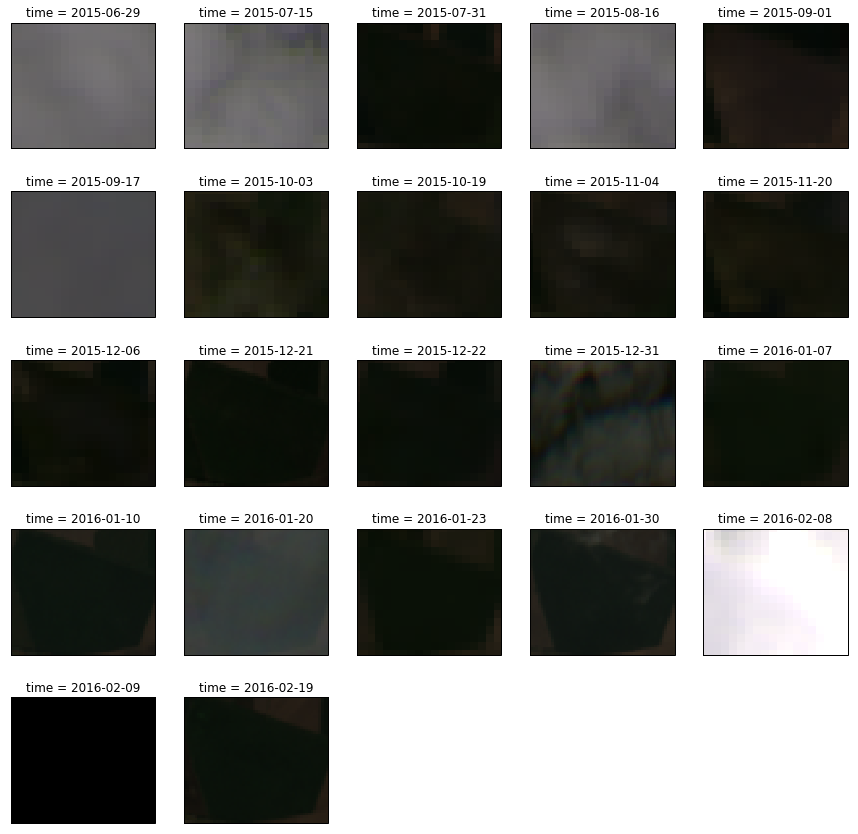

In [23]:
optical_subset = optical_ts.sel(x=xrange,y=yrange,method='nearest').load()

optical_subset.eotemp.plot_RGB()

### Plot time-series

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def plot_polygon_ts(dataset, band, polygon, zlims=(0,1)):
    """
    Plot time-series of a band for points within a polygon of interest
    
    Args:
        dataset (xarray.Dataset): dataset with time series data
        band (str): band to plot
        polygon (shapely.geometry.polygon.Polygon): area of interest
        zlims(tuple(int,int)): limits to y-axis of plot (min,max)
    
    """
    
    bb = polygon.bounds
    
    xrange = np.arange(bb[0], bb[2], 10)
    yrange = np.arange(bb[1], bb[3], 10)
    
    array = dataset[band].sel(x=xrange,y=yrange,method='nearest').load()
    
    fig, axes = plt.subplots(ncols=1)
    
    axes.set_ylim(zlims[0],zlims[1])
    
    for x in array.x.values:
        for y in array.y.values:
            if geometry.point.Point(x,y).within(polygon):
                array.sel(x=x,y=y).plot.line(marker='o')
            else:
                pass
    
    axes.set_title('Interpolated {} time-series'.format(band))
    
    plt.tight_layout()
    
    plt.show()
    

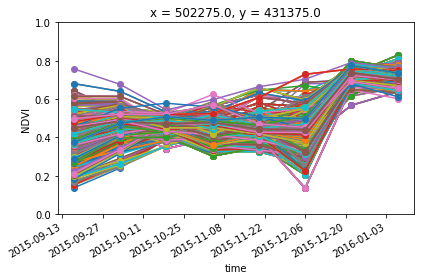

In [19]:
plot_polygon_ts(int_series, 'NDVI', polygon)

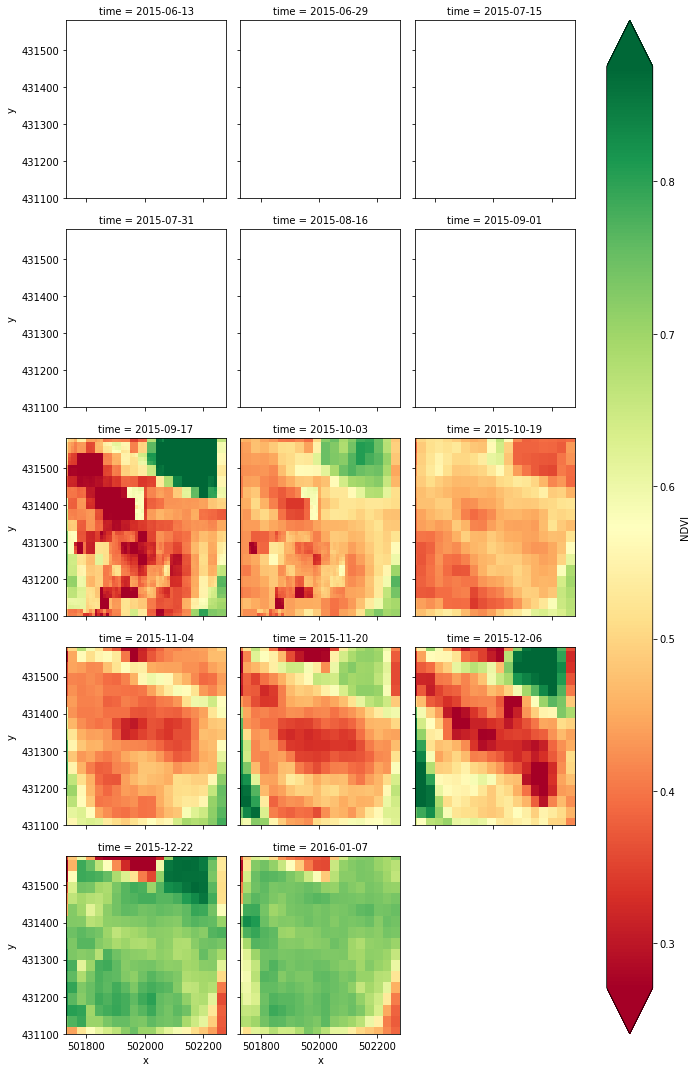

In [21]:
bb = polygon.bounds
xrange = np.arange(bb[0], bb[2], 10)
yrange = np.arange(bb[1], bb[3], 10)

ndvi_region = int_series['NDVI'].sel(x=xrange,y=yrange,method='nearest').load()

ndvi_region.plot(col='time', col_wrap=3, cmap='RdYlGn', robust=True)

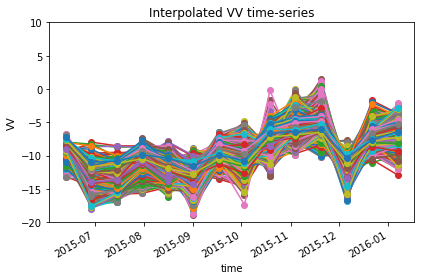

In [22]:
plot_polygon_ts(int_series, 'VV', polygon, zlims=(-20,10))

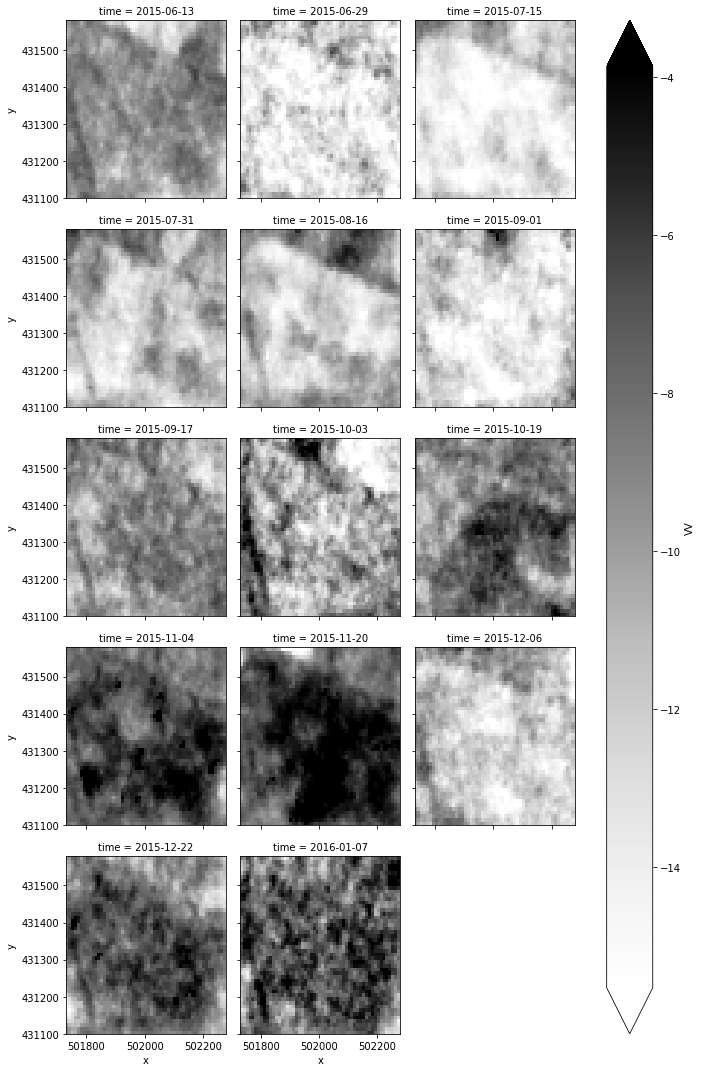

In [24]:
vv_region = int_series['VV'].sel(x=xrange,y=yrange,method='nearest').load()

vv_region.plot(col='time', col_wrap=3, cmap='Greys', robust=True)

### Inspect differences with interpolated dataset

In [27]:
#Retrieve NDVI original dataset
ndvi_orig = xr.open_dataset(vars_location+'NDVI.nc',
                            chunks={'y':100,'x':100,'time':23})
ndvi_orig = ndvi_orig.sortby('time')

In [34]:
def plot_interpolation_diff(original, interpolated, polygon, zlims=(0,1)):
    """
    Plot time-series of a band for points within a polygon of interest
    
    Args:
        dataset (xarray.Dataset): dataset with time series data
        band (str): band to plot
        polygon (shapely.geometry.polygon.Polygon): area of interest
        zlims(tuple(int,int)): limits to y-axis of plot (min,max)
    
    """
    
    bb = polygon.bounds
    
    xrange = np.arange(bb[0], bb[2], 10)
    yrange = np.arange(bb[1], bb[3], 10)
    
    original_ss = original.sel(x=xrange,y=yrange,method='nearest').load()
    interpolated_ss = interpolated.sel(x=xrange,y=yrange,method='nearest').load()
    
    fig, axes = plt.subplots(ncols=2)
    
    axes[0].set_ylim(zlims[0],zlims[1])
    axes[1].set_ylim(zlims[0],zlims[1])
    axes[1].set_xlim(original_ss.time.values[0],original_ss.time.values[-1])
    
    for x in interpolated_ss.x.values:
        for y in interpolated_ss.y.values:
            if geometry.point.Point(x,y).within(polygon):
                original_ss.sel(x=x,y=y).plot.line(ax=axes[0],marker='o')
                interpolated_ss.sel(x=x,y=y).plot.line(ax=axes[1],marker='o')
            else:
                pass
    
    axes[0].set_title('Original time-series')
    axes[1].set_title('Interpolated time-series')
    
    plt.tight_layout()
    
    plt.show()
    

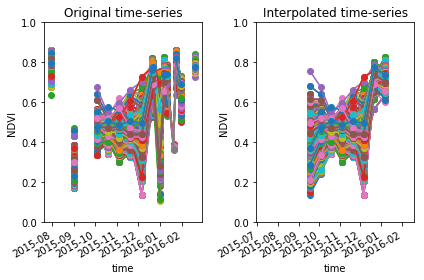

In [35]:
plot_interpolation_diff(ndvi_orig.NDVI, int_series.NDVI, polygon)